# Tutorial about matched filter analysis

First we need to install and import a few packages


In [ ]:
import numpy as np
import sys
!{sys.executable} -m pip install pycbc ligo-common --no-cache-dir
import pylab

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.5/7.5 MB 49.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 201.2/201.2 kB 178.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 147.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.4/45.4 kB 124.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.4/44.4 kB 127.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 30.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.0/51.0 kB 121.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.6/57.6 MB 28.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 107.5 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting req

### Generate waveforms
Matched filtering is used to look for a signal buried in noise, provided that we know how the signal looks like. 
For this tutorial we will use functions from the pycbc package. Pycbc is a pipeline generally used for GW searches,  the complete documentation about its functions can be found here: http://pycbc.org/pycbc/latest/html/.
First we are going to generate waveforms for given binary parameters and plot them.

In [ ]:
from pycbc.waveform import get_td_waveform, get_fd_waveform
from pycbc.waveform import td_approximants, fd_approximants
import matplotlib
import matplotlib.pyplot as plt

#### Plotting waveforms

We start by plotting plus and cross ploarizations for some waveforms. In the function below you have the following arguments:
* approximant : it's the waveform model we use to describe hplus and hcross
* mass1, mass2: masses of the compact objects in solar masses; by convention we give mass1 > mass2
* f_lower: frequency at which the waveform starts to be generated

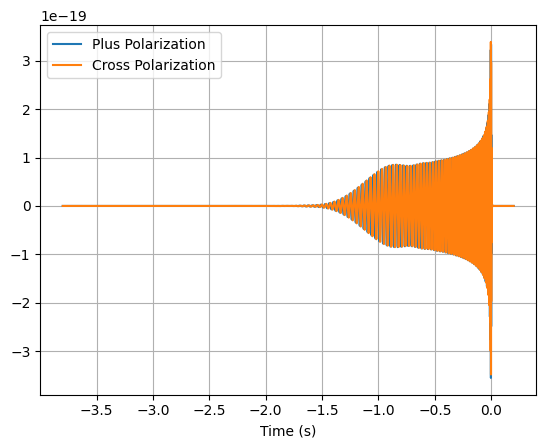

In [ ]:
hp, hc = get_td_waveform(approximant="IMRPhenomD",
                         mass1=15,
                         mass2=15,
                         delta_t=1.0/4096,
                         f_lower=30)
plt.plot(hp.sample_times, hp, label='Plus Polarization')
plt.plot(hp.sample_times, hc, label='Cross Polarization')
plt.xlabel('Time (s)')
plt.legend()
plt.grid()
plt.show()

Zoom in on the merger

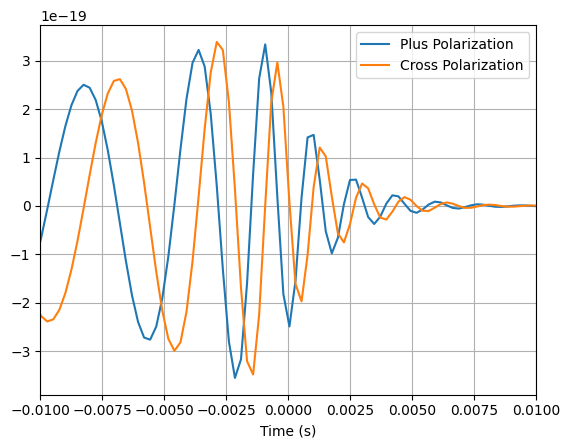

In [ ]:
plt.plot(hp.sample_times, hp, label='Plus Polarization')
plt.plot(hp.sample_times, hc, label='Cross Polarization')
plt.xlabel('Time (s)')
plt.xlim(-.01, .01)
plt.legend()
plt.grid()
plt.show()

This is in time domain, but we know gravitational wave signals change also in frequency. Now we plot the same waveform, but in frequency domain.

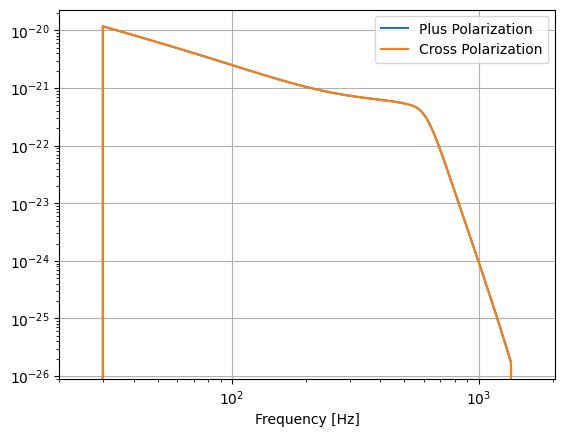

In [ ]:
hp, hc = get_fd_waveform(approximant="IMRPhenomD",
                         mass1=15,
                         mass2=15,
                         delta_f = 1./16.,
                         f_lower=30)
plt.plot(hp.sample_frequencies, abs(hp), label='Plus Polarization')
plt.plot(hp.sample_frequencies, abs(hc), label='Cross Polarization')
plt.xlabel('Frequency [Hz]')
plt.xscale('log')
plt.yscale('log')
plt.xlim(20,2048)
plt.legend()
plt.grid()
plt.show()

### How do waveform change with source parameters
 
Gravitational wave signals change when we change the source parameters, like masses. Below we plot different signals for different mass values, both in time and frequency (for simplicity we assume mass1= mass2, but this can also not be the case).

Text(0.5, 0, 'Time [s]')

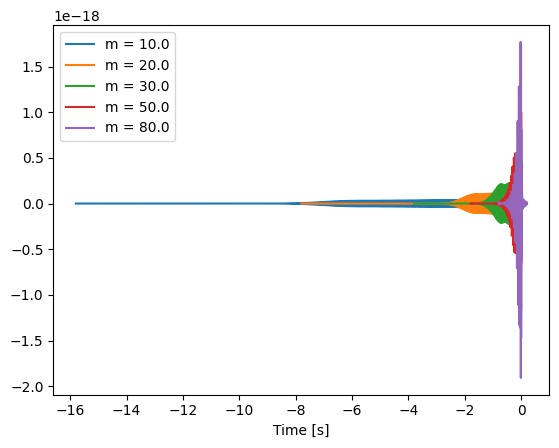

In [ ]:
for mass in [10., 20., 30., 50., 80.]:
    hp, hc = get_td_waveform(approximant="IMRPhenomD",
                         mass1=mass,
                         mass2=mass,
                         delta_t=1.0/4096,
                         f_lower=20)
    
    plt.plot(hp.sample_times, hp, label = 'm = {}'.format(mass))
    
plt.legend()
plt.xlabel('Time [s]')  

Text(0.5, 0, 'Frequency [s]')

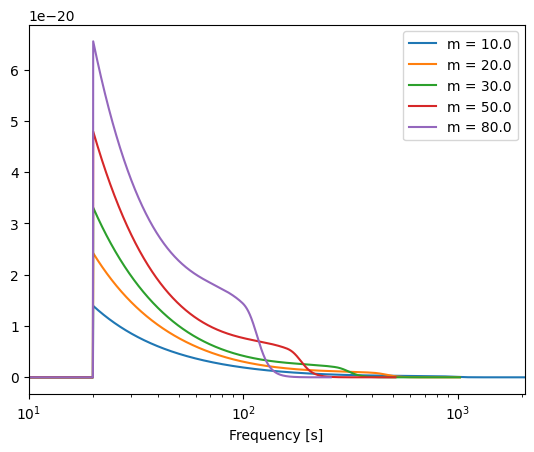

In [ ]:
for mass in [10., 20., 30., 50., 80.]:
    hp, hc = get_fd_waveform(approximant="IMRPhenomD",
                         mass1=mass,
                         mass2=mass,
                         delta_f=1.0/16.0,
                         f_lower=20)
    
    plt.plot(hp.sample_frequencies, abs(hp), label = 'm = {}'.format(mass))
    
plt.legend()
plt.xscale('log')
plt.xlim(10.,2048.)
plt.xlabel('Frequency [s]')  

### Matched filetring

We will use matched filtering to find the gravitational wave signal in a stretch of data. We start by loading the data frame and plotting it. Here we use data from Hanford detector ('H1'), but in principle we have data also for Livingstone ('L1') and Virgo ('V1'). To read the frame data we use the pycbc function `frame.read_frame` which takes as arguments the name of the frame file (files with '.gwf' extension) and something called 'channel name' (without going into details, in this notebook channel names will always be called "det:TEST_INJECTED", where 'det'is the name of the detector).

In [ ]:
### The following line are needed to upload the frames files only if you are usig google colab.
### With jupyter notebook you can just copy the frame files in the same location where the notebook is.


from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(name=fn, length=len(uploaded[fn])))


Saving frame1_H1.gwf to frame1_H1.gwf
Saving frame1_L1.gwf to frame1_L1.gwf
Saving frame1_V1.gwf to frame1_V1.gwf
Saving frame2_H1.gwf to frame2_H1.gwf
Saving frame2_L1.gwf to frame2_L1.gwf
Saving frame2_V1.gwf to frame2_V1.gwf
Saving frame3_H1.gwf to frame3_H1.gwf
Saving frame3_L1.gwf to frame3_L1.gwf
Saving frame3_V1.gwf to frame3_V1.gwf
Saving frame4_H1.gwf to frame4_H1.gwf
Saving frame4_L1.gwf to frame4_L1.gwf
Saving frame5_H1.gwf to frame5_H1.gwf
Saving frame5_L1.gwf to frame5_L1.gwf
User uploaded file "frame1_H1.gwf" with length 4025151 bytes
User uploaded file "frame1_L1.gwf" with length 4025051 bytes
User uploaded file "frame1_V1.gwf" with length 4025558 bytes
User uploaded file "frame2_H1.gwf" with length 4025269 bytes
User uploaded file "frame2_L1.gwf" with length 4025234 bytes
User uploaded file "frame2_V1.gwf" with length 4025528 bytes
User uploaded file "frame3_H1.gwf" with length 4025176 bytes
User uploaded file "frame3_L1.gwf" with length 4025057 bytes
User uploaded file

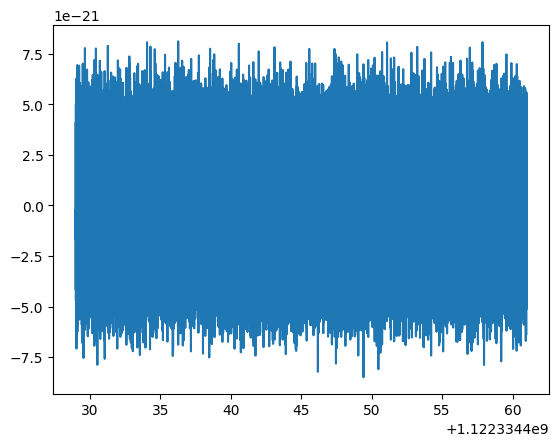

In [ ]:
from pycbc import frame
data = frame.read_frame('frame1_H1.gwf', 'H1:TEST_INJECTED')
plt.plot(data.sample_times, data)

We have ~30 seconds of data, and we want to find exactly where the signal is. As a first step, we remove the low frequency content and downsample the data to 2048Hz. This is necessary because the detectors' noise at lower frequencies is too high. We also need to resample to a frequency more convenient for the analysis (higher frequency means also heavier computation). Then we crop the beginning and end of the data, to remove the possible 'spikes' introduced by te filter applied in the previous steps.

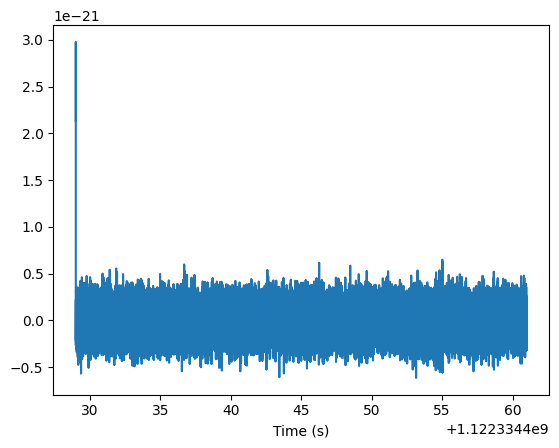

In [ ]:
from pycbc.psd import interpolate, inverse_spectrum_truncation
from pycbc.filter import resample_to_delta_t, highpass

data = resample_to_delta_t(highpass(data, 15.0), 1.0/2048)

plt.plot(data.sample_times, data)
plt.xlabel('Time (s)')
plt.show()

cond = data.crop(2, 2)

#### Estimate the PSD
In order to use matched filtering, we need to have an estimate of the power spectral density PSD ($S_n(f)$ in the lecture notes) in the data. Here the PSD is estimated from data with a Welch method, and we choose a segement length of 4s.

(30, 1024)

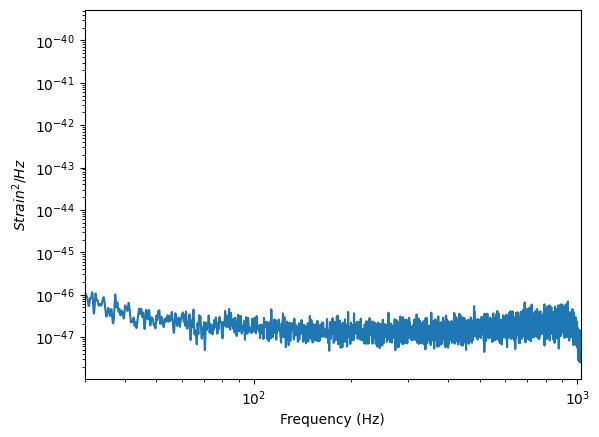

In [ ]:
psd = cond.psd(4)

# To make PSD compatible with our data, we need to resample to to the same delta_f
psd = interpolate(psd, cond.delta_f)

# In the data, we removed frequencies below 15Hz.
# To use the PSD as a filter on our data, we need to also 'inform' the PSD about the highpass filtering
psd = inverse_spectrum_truncation(psd, int(4 * cond.sample_rate),
                                  low_frequency_cutoff=20)

plt.loglog(psd.sample_frequencies, psd)
plt.ylabel('$Strain^2 / Hz$')
plt.xlabel('Frequency (Hz)')
plt.xlim(30, 1024)

#### Template
Create the template for the matched filter search: here for simplicity we assume we know that $m_1 = m_2 \simeq 50$.

57344 57344


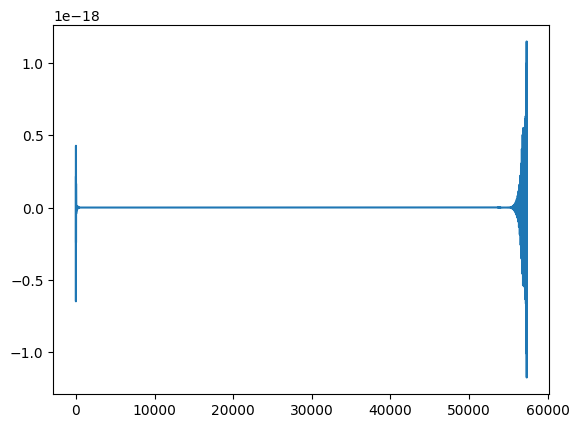

In [ ]:
m = 50 # Solar masses
hp, hc = get_td_waveform(approximant="IMRPhenomD",
                     mass1=m,
                     mass2=m,
                     delta_t=cond.delta_t,
                     f_lower=20)

# We resize the vector containing the template to match our data
hp.resize(len(cond))
print(len(cond), len(hp))
template = hp.cyclic_time_shift(hp.start_time)
plt.plot(template)
plt.show()

Apply the `matched_filter` function from pycbc, which takes as arguments: template, data in which we want to look for the signal, psd and minimum frequency at which we want to start the analysis. We expect the signal to be where the matched flter signal-to-noise (SNR) (the 'detection statistics' $\rho$ in the lecture notes) is maximum.

57344


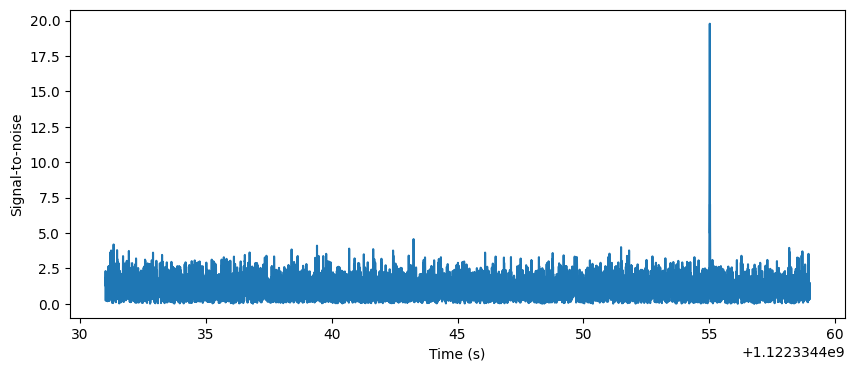

We found a signal at 1122334455.020996s with SNR 19.78266141072154


In [ ]:
from pycbc.filter import matched_filter
import numpy

snr = matched_filter(template, cond,
                     psd=psd, low_frequency_cutoff=20)
print(len(snr))
snr = snr[10:-10]
plt.figure(figsize=[10, 4])
plt.plot(snr.sample_times, abs(snr))
plt.ylabel('Signal-to-noise')
plt.xlabel('Time (s)')
plt.show()

peak = abs(snr).numpy().argmax()
snrp = snr[peak]
time = snr.sample_times[peak]

print("We found a signal at {}s with SNR {}".format(time, 
                                                    abs(snrp)))

### To do
Find where the signal is in frame2. You can also try other detectors' data. For simplicity assume you know $m_1 = m2 \simeq 18$

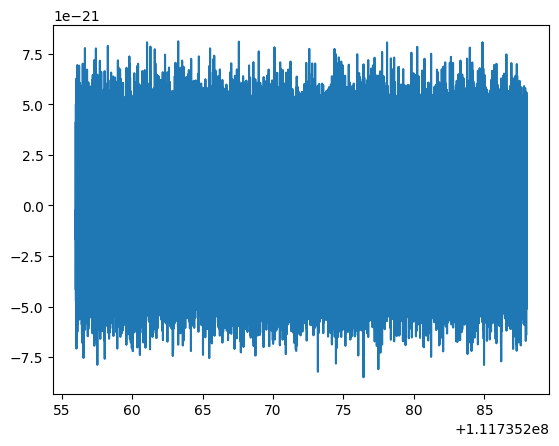

In [ ]:
from pycbc import frame
data = frame.read_frame('frame2_H1.gwf', 'H1:TEST_INJECTED')
plt.plot(data.sample_times, data)

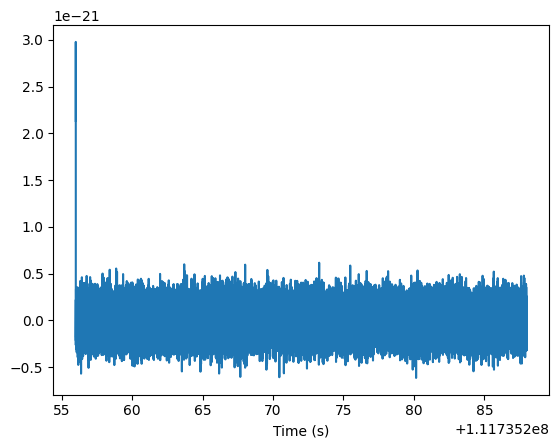

In [ ]:
from pycbc.psd import interpolate, inverse_spectrum_truncation
from pycbc.filter import resample_to_delta_t, highpass

data = resample_to_delta_t(highpass(data, 15.0), 1.0/2048)

plt.plot(data.sample_times, data)
plt.xlabel('Time (s)')
plt.show()


(30, 1024)

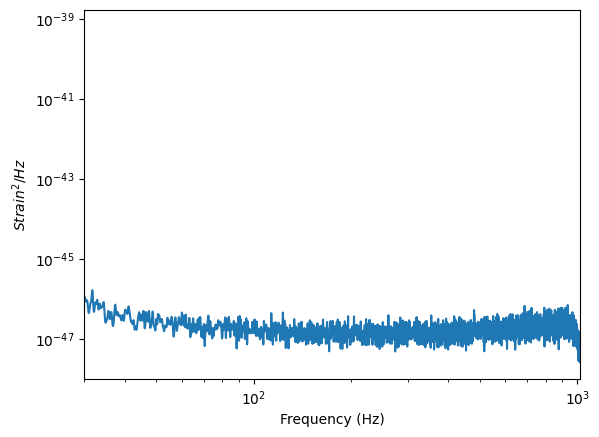

In [ ]:
cond = data.crop(2, 2)

psd = cond.psd(4)

# To make PSD compatible with our data, we need to resample to to the same delta_f
psd = interpolate(psd, cond.delta_f)

# In the data, we removed frequencies below 15Hz.
# To use the PSD as a filter on our data, we need to also 'inform' the PSD about the highpass filtering
psd = inverse_spectrum_truncation(psd, int(4 * cond.sample_rate),
                                  low_frequency_cutoff=20)

plt.loglog(psd.sample_frequencies, psd)
plt.ylabel('$Strain^2 / Hz$')
plt.xlabel('Frequency (Hz)')
plt.xlim(30, 1024)

57344 57344


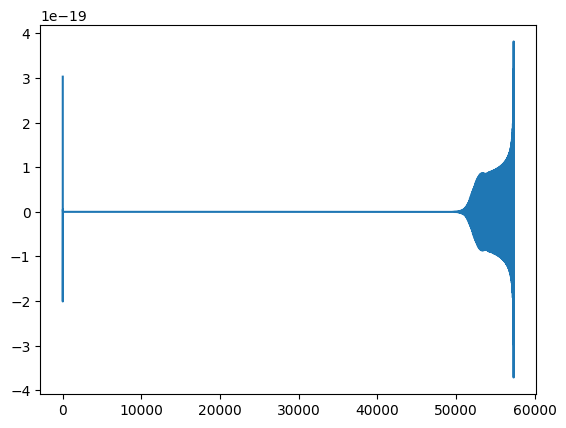

In [ ]:
m = 18 # Solar masses
hp, hc = get_td_waveform(approximant="IMRPhenomD",
                     mass1=m,
                     mass2=m,
                     delta_t=cond.delta_t,
                     f_lower=20)

# We resize the vector containing the template to match our data
hp.resize(len(cond))
print(len(cond), len(hp))
template = hp.cyclic_time_shift(hp.start_time)
plt.plot(template)
plt.show()

57344


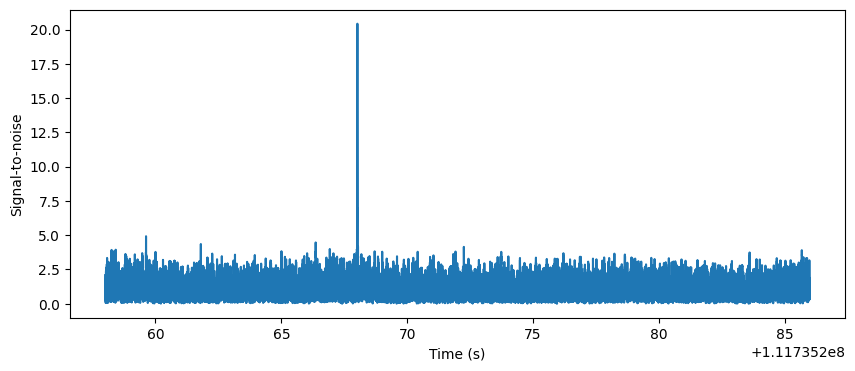

We found a signal at 111735268.02148438s with SNR 20.422338537575097


In [ ]:
from pycbc.filter import matched_filter
import numpy

snr = matched_filter(template, cond,
                     psd=psd, low_frequency_cutoff=20)
print(len(snr))
snr = snr[10:-10]
plt.figure(figsize=[10, 4])
plt.plot(snr.sample_times, abs(snr))
plt.ylabel('Signal-to-noise')
plt.xlabel('Time (s)')
plt.show()

peak = abs(snr).numpy().argmax()
snrp = snr[peak]
time = snr.sample_times[peak]

print("We found a signal at {}s with SNR {}".format(time, 
                                                    abs(snrp)))

### Match filter without knowing the mass
In general, when we look for a GW signal in a strain of data, we don't know the source properties in advance. For frame3, frame4 and frame5, try to find where the signal is and what is the total mass of the system, assuming $m_1 = m_2$, and that $m_{tot} \in [10.,60.] M_\odot$.
Suggestion: we assume the correct time and total mass of the signal are the values for which the matched filter SNR is maximum for all the detectors.

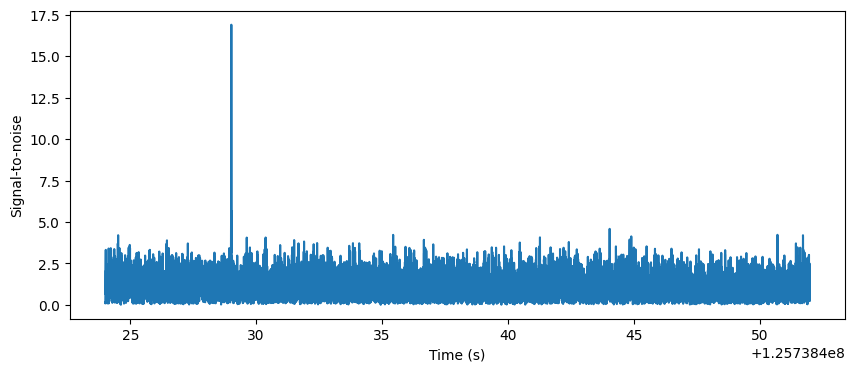

For frame 3 of detector H1 and mass 35, we found a signal at 125738429.00585938s with SNR 16.906088669123715


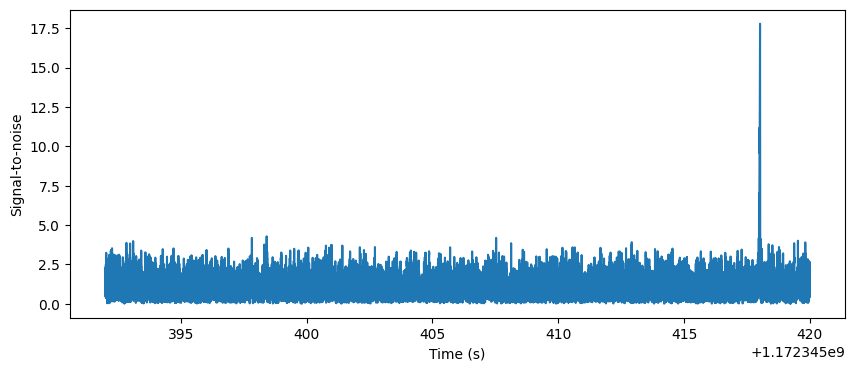

For frame 4 of detector H1 and mass 28, we found a signal at 1172345418.008789s with SNR 17.794504587650056


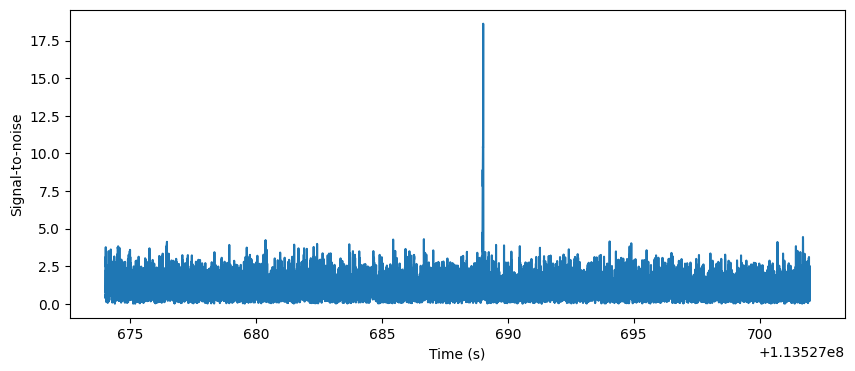

For frame 5 of detector H1 and mass 35, we found a signal at 113527689.0131836s with SNR 18.629713237358267


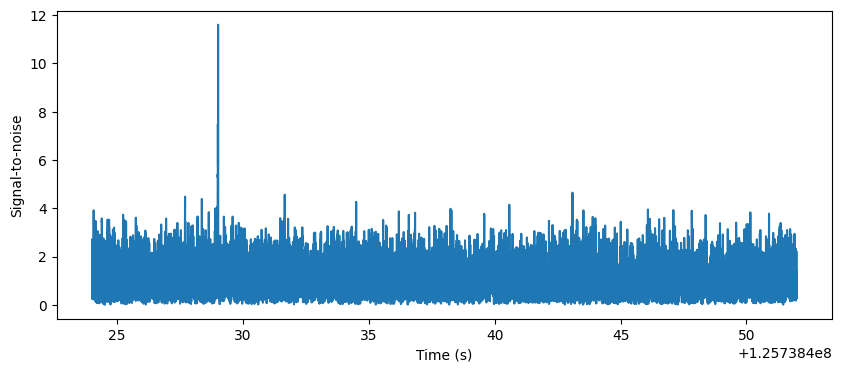

For frame 3 of detector L1 and mass 36, we found a signal at 125738429.00341797s with SNR 11.606583417534488


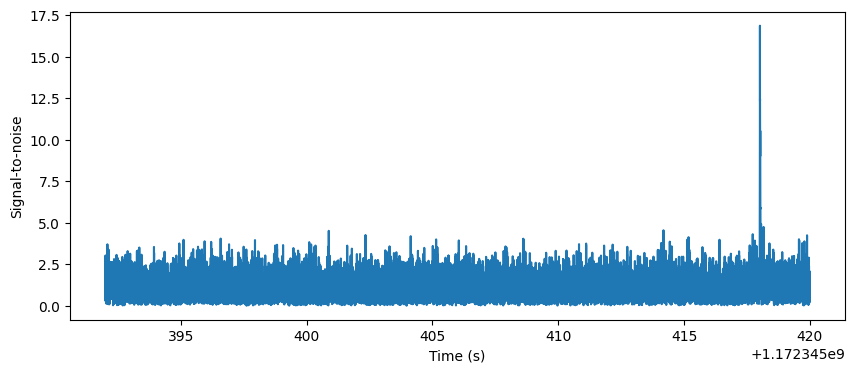

For frame 4 of detector L1 and mass 26, we found a signal at 1172345418.0014648s with SNR 16.87530981393983


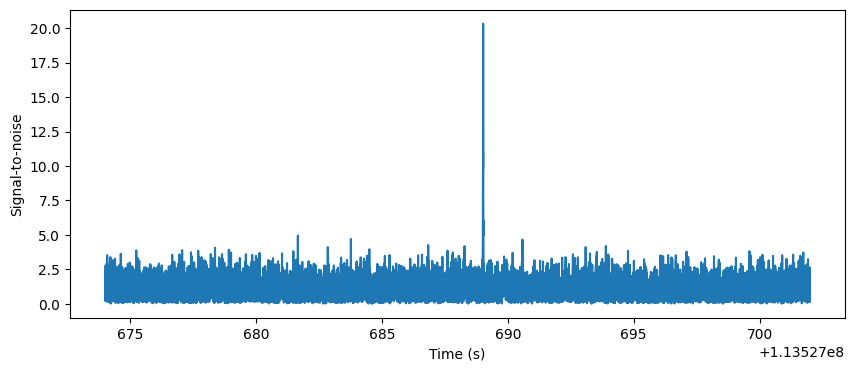

For frame 5 of detector L1 and mass 34, we found a signal at 113527689.01171875s with SNR 20.32670645085362


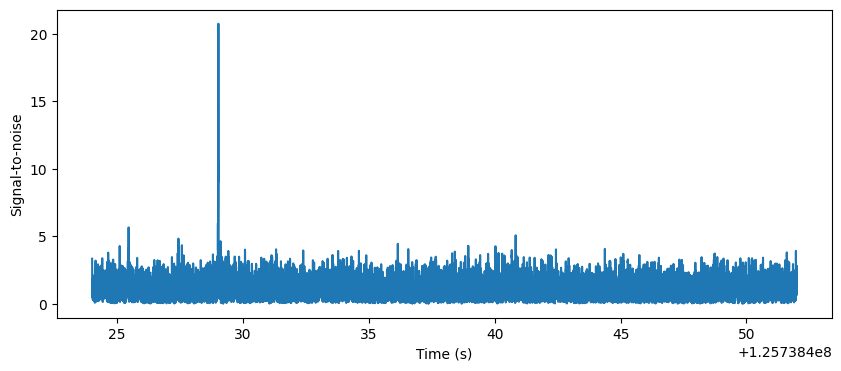

For frame 3 of detector V1 and mass 36, we found a signal at 125738429.01464844s with SNR 20.756889006653378


In [ ]:
from pycbc import frame
from pycbc.psd import interpolate, inverse_spectrum_truncation
from pycbc.filter import resample_to_delta_t, highpass
from pycbc.filter import matched_filter
import numpy

detectors = ["H1", "L1", "V1"]
for detector in detectors:
  if detector == "V1":
    maxframe = 3
  else:
    maxframe = 5
  for f in range(3, maxframe + 1):
    data = frame.read_frame('frame' + str(f) + '_' + detector + '.gwf', detector + ':TEST_INJECTED')
    data = resample_to_delta_t(highpass(data, 15.0), 1.0/2048)
    cond = data.crop(2, 2)

    psd = cond.psd(4)

    # To make PSD compatible with our data, we need to resample to to the same delta_f
    psd = interpolate(psd, cond.delta_f)

    # In the data, we removed frequencies below 15Hz.
    # To use the PSD as a filter on our data, we need to also 'inform' the PSD about the highpass filtering
    psd = inverse_spectrum_truncation(psd, int(4 * cond.sample_rate),
                                      low_frequency_cutoff=20)
    
    biggest_snrp = 0
    biggest_mass = 0
    biggest_snr = []

    for m in range(5, 60):
      hp, hc = get_td_waveform(approximant="IMRPhenomD",
                          mass1=m,
                          mass2=m,
                          delta_t=cond.delta_t,
                          f_lower=20)

      # We resize the vector containing the template to match our data
      hp.resize(len(cond))
      template = hp.cyclic_time_shift(hp.start_time)


      snr = matched_filter(template, cond,psd=psd, low_frequency_cutoff=20)
      snr = snr[10:-10]

      peak = abs(snr).numpy().argmax()
      snrp = snr[peak]
      time = snr.sample_times[peak]

      if snrp > 8:
        if snrp > biggest_snrp:
          biggest_snrp = snrp
          biggest_mass = m
          biggest_snr = snr

      
    plt.figure(figsize=[10, 4])
    plt.plot(biggest_snr.sample_times, abs(biggest_snr))
    plt.ylabel('Signal-to-noise')
    plt.xlabel('Time (s)')
    plt.show()

    print("For frame " + str(f) + " of detector " + detector + " and mass " + str(biggest_mass) + ", we found a signal at {}s with SNR {}".format(time, 
                                                      abs(biggest_snrp)))

## Real data

Now analyze the segment of data with GW150914, the very first gravitational wave detection. With the same procedure as above, find the time and total mass of the signal, assuming $m_1 = m_2$ and $m_{tot} \in [10.,60.]$. For simplicity, you can just look at detector 'H1'. The functions to read frames for real data are given below:

In [ ]:
from pycbc.catalog import Merger
from pycbc.filter import resample_to_delta_t, highpass

# This function imports a strain of data around the GW150914 event
merger = Merger("GW150914")

# Get the data from the Hanford detector
strain = merger.strain('H1')

### Bonus: Plot data and template

Once you have the conditioned data, the estinated psd and the correct template, we can plot the data and the template to see how they look.

In [ ]:
from pycbc.filter import sigma
# The time, amplitude, and phase of the SNR peak tell us how to align
# our proposed signal with the data.

# Shift the template to the peak time
dt = time - cond.start_time
aligned = template.cyclic_time_shift(dt)

# scale the template so that it would have SNR 1 in this data
aligned /= sigma(aligned, psd=psd, low_frequency_cutoff=20.0)

# Scale the template amplitude and phase to the peak value
aligned = (aligned.to_frequencyseries() * snrp).to_timeseries()
aligned.start_time = conditioned.start_time

In [ ]:
# We do it this way so that we can whiten both the template and the data
white_data = (conditioned.to_frequencyseries() / psd**0.5).to_timeseries()

# apply a smoothing of the turnon of the template to avoid a transient
# from the sharp turn on in the waveform.
tapered = aligned.highpass_fir(30, 512, remove_corrupted=False)
white_template = (tapered.to_frequencyseries() / psd**0.5).to_timeseries()

white_data = white_data.highpass_fir(30., 512).lowpass_fir(300, 512)
white_template = white_template.highpass_fir(30, 512).lowpass_fir(300, 512)

# Select the time around the merger
white_data = white_data.time_slice(merger.time-.2, merger.time+.1)
white_template = white_template.time_slice(merger.time-.2, merger.time+.1)

plt.figure(figsize=[15, 3])
plt.plot(white_data.sample_times, white_data, label="Data")
plt.plot(white_template.sample_times, white_template, label="Template")
plt.legend()
plt.show()